## Laplace transforms in SymPy

The Laplace transform is 

$$\mathcal{L}\{f(t)\} = \int_0^\infty f(t) e^{-st} \mathrm{d}t $$

The Laplace transform is a transformation form the time-domain to the s-domain.
$t$ as the independent variable is replaced with $s$ as the independent variable.

#### Advantage:
- Differentiation with respect to time becomes a multiplication by $s$. 
- Integration with respect to time becomes a division by $s$.
- Convolution of two functions becomes the multiplication of the two functions.
- The Laplace transform is a linear operation: $\mathcal{L}\{a f_1(t) + b f_2(t)\} = a\mathcal{L}\{f_1(t)\} + b\mathcal{L}\{f_2(t)\}$

#### Limitations:
- The Laplace tranform only exists for functions for which the integral $\mathcal{L}\{f(t)\} = \int_0^\infty f(t) e^{-st} \mathrm{d}t $ is bounded.

In [1]:
import sympy
sympy.init_printing()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's define some symbols to work with. 

In [3]:
 s = sympy.symbols('s')
t = sympy.symbols('t', real=True)
a = sympy.symbols('a', real=True, positive=True)

### Direct evaluation

We start with a simple function

In [4]:
f = sympy.exp(-a*t)
f

We can evaluate the integral directly using `integrate`:

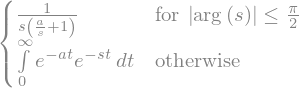

In [5]:
sympy.integrate(f*sympy.exp(-s*t), (t, 0, sympy.oo))

### Library function

This works, but it is a bit cumbersome to have all the extra stuff in there. 

Sympy provides a function called `laplace_transform` which does this more efficiently. By default it will return conditions of convergence as well (recall this is an improper integral, with an infinite bound, so it will not always converge).

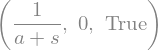

In [6]:
sympy.laplace_transform(f, t, s)

If we want just the function, we can specify `noconds=True`.

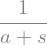

In [7]:
F = sympy.laplace_transform(f, t, s, noconds=True)
F

We will find it useful to define a quicker version of this:

In [8]:
def L(f):
    return sympy.laplace_transform(f, t, s, noconds=True)

Inverses are simple as well,

In [9]:
def invL(F):
    return sympy.inverse_laplace_transform(F, s, t)

In [10]:
invL(F)

### What is that θ?

The unit step function is also known as the Heaviside step function. We will see this function often in inverse laplace transforms. It is typeset as $\theta(t)$ by sympy.

In [11]:
sympy.Heaviside(t)

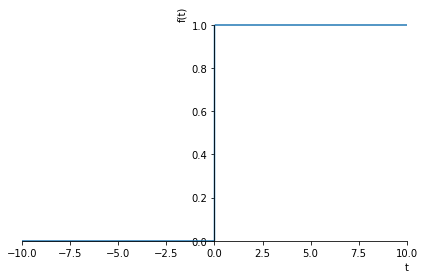

In [12]:
sympy.plot(sympy.Heaviside(t));

Look at the difference between $f$ and the inverse laplace transform we obtained, which contains the unit step to force it to zero before $t=0$.

In [13]:
invL(F).subs({a: 2})

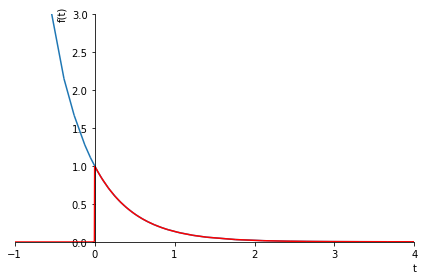

In [14]:
p = sympy.plot(f.subs({a: 2}), invL(F).subs({a: 2}), 
               xlim=(-1, 4), ylim=(0, 3), show=False)
p[1].line_color = 'red'
p.show()

### Reproducing standard transform table

Let's see if we can match the functions in the table

In [15]:
omega = sympy.Symbol('omega', real=True)
exp = sympy.exp
sin = sympy.sin
cos = sympy.cos
functions = [1,
         t,
         exp(-a*t),
         t*exp(-a*t),
         t**2*exp(-a*t),
         sin(omega*t),
         cos(omega*t),
         1 - exp(-a*t),
         exp(-a*t)*sin(omega*t),
         exp(-a*t)*cos(omega*t),
         ]
functions

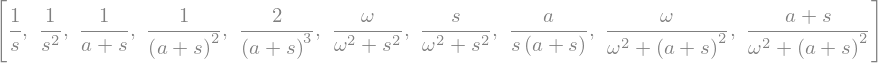

In [16]:
Fs = [L(f) for f in functions]
Fs

We can make a pretty good approximation of the table with a little help from pandas

In [17]:
from pandas import DataFrame

In [18]:
def makelatex(args):
    return ["$${}$$".format(sympy.latex(a)) for a in args]

In [19]:
DataFrame(list(zip(makelatex(functions), makelatex(Fs))))

,0,1
0,$$1$$,$$\frac{1}{s}$$
1,$$t$$,$$\frac{1}{s^{2}}$$
2,$$e^{- a t}$$,$$\frac{1}{a + s}$$
3,$$t e^{- a t}$$,$$\frac{1}{\left(a + s\right)^{2}}$$
4,$$t^{2} e^{- a t}$$,$$\frac{2}{\left(a + s\right)^{3}}$$
5,$$\sin{\left(\omega t \right)}$$,$$\frac{\omega}{\omega^{2} + s^{2}}$$
6,$$\cos{\left(\omega t \right)}$$,$$\frac{s}{\omega^{2} + s^{2}}$$
7,$$1 - e^{- a t}$$,$$\frac{a}{s \left(a + s\right)}$$
8,$$e^{- a t} \sin{\left(\omega t \right)}$$,$$\frac{\omega}{\omega^{2} + \left(a + s\right...
9,$$e^{- a t} \cos{\left(\omega t \right)}$$,$$\frac{a + s}{\omega^{2} + \left(a + s\right)...


### More complicated inverses

Why doesn't the table feature more complicated functions? Because higher-order rational functions can be written as sums of simpler ones through application of partial fractions expansion.

In [20]:
F = ((s + 1)*(s + 2)* (s + 3))/((s + 4)*(s + 5)*(s + 6))

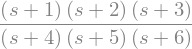

In [21]:
F

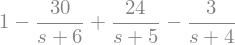

In [22]:
F.apart(s)

Even sympy can benefit from a little help sometimes. When we try to calculate the inverse of $F$ we get a bit of a nasty answer:

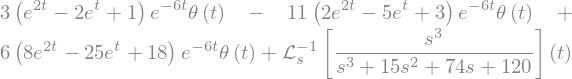

In [23]:
invL(F)

Perhaps it looks better if we simplify?

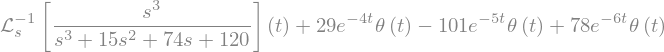

In [24]:
invL(F).simplify()

No, it still features an "unknown" laplace transform. If we do the partial fractions expansion first, we get a clean answer:

In [25]:
invL(F.apart(s))